In [1]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import statsmodels
from typing import Tuple, List
import scipy
from scipy.stats import skew, kurtosis
import numpy as np
import os
import powerlaw
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import poisson
from scipy.stats import chisquare
from statsmodels.tsa.stattools import adfuller
import seaborn as sns



In [2]:
def pull_data(in_data, isReal = False):
    if isReal:
        data = pd.DataFrame()
        data["midprice"] = in_data.iloc[:, 1]
        data["returns"] = data["midprice"].pct_change(5)
        with pd.option_context("mode.use_inf_as_null", True):
            data = data.dropna()

        return data

    data = pd.DataFrame()

    data["midprice"] = in_data["curr_mp"]
    data["spread"] = in_data["spread"]

    data["returns"] = data["midprice"].pct_change(5)

    data["bid_volume"] = np.sum(
        [
            in_data["bid_1"],
            in_data["bid_2"],
            in_data["bid_3"],
            in_data["bid_4"],
            in_data["bid_5"],
        ],
        axis=0,
    )
    data["ask_volume"] = np.sum(
        [
            in_data["ask_1"],
            in_data["ask_2"],
            in_data["ask_3"],
            in_data["ask_4"],
            in_data["ask_5"],
        ],
        axis=0,
    )
    # volumes = np.mean(
    #     [
    #         in_data["bid_5"],
    #         in_data["bid_4"],
    #         in_data["bid_3"],
    #         in_data["bid_2"],
    #         in_data["bid_1"],
    #         in_data["ask_1"],
    #         in_data["ask_2"],
    #         in_data["ask_3"],
    #         in_data["ask_4"],
    #         in_data["ask_5"],
    #     ],
    #     axis=1,
    # )
    data["volume_inbalance"] = np.subtract(data["bid_volume"], data["ask_volume"])

    with pd.option_context("mode.use_inf_as_null", True):
        data = data.dropna()
    
    return data


In [3]:
def collect_data(path):
    csv_files = [file for file in os.listdir(path)]
    sim = {"lt":[], "mm":[]}
    for file in csv_files:
        file_name, e = os.path.splitext(file)
        
        if file_name.startswith("sep_trader_lt"):
            sim["lt"].append(pd.read_csv(os.path.join(path, file)))
        elif file_name.startswith("sep_trader_mm"):
            sim["mm"].append(pd.read_csv(os.path.join(path, file)))
    return sim


In [4]:
def modify_mm_data(data):
    #list(data class) - list(sims) - dict(mm/lt) - list(agents) - df(agent)
    mm_data = []
    for i in range(len(data)):
        mm_data.append(pull_data(data[i]["mm"][0]))
    return mm_data

In [5]:
def toge_helper(agg_value_list, order):
    #calculate mean:
    mean = [round(sum(value[1:])/len(value[1:]),2) for value in agg_value_list]
    #fill empty cells with nan
    max_len = max(len(value) for value in agg_value_list)
    for i in range(len(agg_value_list)):
        while len(agg_value_list[i]) < max_len:
            agg_value_list[i].append("nan")
    #add mean
    for i in range(len(agg_value_list)):
        agg_value_list[i].append(mean[i])
    col_names = [x for x in range(1,max_len+1)]+["Mean"]

    df = pd.DataFrame(index = order, columns=col_names)
    #transpose data to put into df
    transposed = np.transpose(agg_value_list)
    for i in range(len(transposed)):
        df[col_names[i]] = transposed[i]
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)
    print(df)

In [6]:
def toge_statistics(data_batch, types, order = ["Train", "Train2", "Test", "Flash_Train", "Flash_Test", "Non_Train"]):
    #data_batch: list(data class) - list(sims) - dict(mm/lt) - list(agents) - df(agent)
    for stat_type in types:
        if stat_type == "Price_std":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round(np.std(data[sim_num]["mm"][0]["curr_mp"]),2))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)
        
        elif stat_type == "Returns_Kurtosis":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round(kurtosis(data[sim_num]["mm"][0]["curr_mp"].pct_change(5).dropna()),2))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)

        elif stat_type == "Average_Inventory":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round(np.mean(data[sim_num]["mm"][0]["total_volume"].dropna()),2))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)
        
        elif stat_type == "Average_Spread":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round(np.mean(data[sim_num]["mm"][0]["spread"].dropna()),2))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)
        
        elif stat_type == "Average_Depth":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round((np.mean(data[sim_num]["mm"][0]["Bid_depth"].dropna()) + 
                        np.mean(data[sim_num]["mm"][0]["Ask_depth"].dropna()))/2,2))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)
        print()


In [7]:
def plot_percentile(avgs, title, col, index):
    min_len = min(len(arr) for arr in avgs)
    avgs_trimmed = [arr[:min_len] for arr in avgs]
    avg = np.mean(avgs_trimmed, axis=0)
    percentile_75 = np.percentile(avgs_trimmed, 75, axis=0)
    percentile_25 = np.percentile(avgs_trimmed, 25, axis=0)
    
    plt.subplot(1, 2, index) 
    plt.plot(avg, color=col, label='Average')
    plt.fill_between(range(len(avg)), percentile_75, percentile_25, color=col, alpha=0.2, label='25th-75th Percentile')
    plt.title(title)

In [8]:
def agent_plot(data, type, data_class):
    if type == "reward":
        window = 100
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["rew"].rolling(window).mean().dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["reward"].rolling(window).mean().dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('Reward')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)
    
    elif type == "inv_pnl":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["inv_pnl"].dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["change_inven_pnl"].dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('PnL')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)

    elif type == "cum_pnl":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["pnl"].cumsum().dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["recent_pl_change"].cumsum().dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('PnL')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)
    
    elif type == "inventory":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["inv"].dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["current_inventory"].dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('Shares')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)


    plt.show()

In [9]:
def plot(data, type, data_class):

    if type == "mid price":
        if data_class == "Real":
            plt.plot(data[0]["midprice"])
        else:
            for i in range(len(data)):
                if max(data[i]["midprice"]) <120:
                    plt.plot(data[i]["midprice"])
        plt.xlabel("Step")
        plt.ylabel("Price")
        plt.title(f"{data_class} Mid Price Movements")
    

    elif type == "normal dist":
        for i in range(len(data)):
            x = data[i]["returns"]
            plt.hist(x, bins=30, alpha=0.3,range=(-0.001, 0.001))
            # sns.histplot(x, bins=30, alpha=0.3,range=(-0.001, 0.001), kde = True)      
            # sns.histplot(x, kde = True)    
            # plt.xlim = (-0.001, 0.001)
        plt.xlabel("Returns")
        plt.ylabel("Count")
        plt.title(f"{data_class} Fitted Normal Dist Line")


    elif type == "return autocorr":
        #marker_styles = ['o', 's', '^', 'x', 'D', 'p', '*', 'H', 'v', '8']
        acf_data = []
        for i in range(len(data)):
            nlags = 10
            temp = acf(data[i]["returns"], nlags=nlags)
            acf_data.append(temp)
            # for j in range(nlags):
            #     acf_data[j].append(temp[j])
            #     print(acf_data[j])
        acf_data = list(map(list, zip(*acf_data)))
        plt.boxplot(acf_data)
            #plt.scatter(range(len(acf_data)), acf_data, marker = marker_styles[i])

        plt.title(f"{data_class} Returns Autocorrelation")
        plt.axhline(y=0, color='red', linestyle='--')


    elif type == "returns statistics":
        plt.figure(figsize=(10, 4)) 
        table = []
        crit = 0
        sign = 0
        for i in range(len(data)):
            skewness = skew(data[i]["returns"])
            kurt = kurtosis(data[i]["returns"])
            result = anderson(data[i]["returns"])
            statistics = result.statistic
            crit = result.critical_values
            sign = result.significance_level
            table.append({'Key': i+1, 'Skewness': skewness, 'Kurtosis': kurt, "Anderson": statistics})
        table_df = pd.DataFrame(table)
        print(f"{data_class} #################")
        print(table_df)
        print("Critical Values:", crit)
        print("Significance Levels:", sign)

        # plt.subplot(1, 3, 1) 
        # plt.bar(table_df['Key'], table_df['Skewness'], alpha=0.8)
        # plt.ylabel('Values')
        # plt.title(f"{data_class} Comparison of Skewness")

        # plt.subplot(1, 3, 2)
        # plt.bar(table_df['Key'], table_df['Kurtosis'], alpha=0.6)
        # plt.ylabel('Values')
        # plt.title(f"{data_class} Comparison of Kurtosis")

        # plt.subplot(1, 3, 3) 
        # plt.bar(table_df['Key'], table_df['Anderson'])
        # plt.ylabel('Values')
        # plt.title(f"{data_class} Comparison of Anderson's statistic")

    elif type == "spread statistics":
        table = []
        def poisson_distribution(x, lam): return poisson.pmf(x, lam)
        for i in range(len(data)):
            #param, _ = curve_fit(poisson_distribution, np.arange(max(data[i]["spread"])), np.bincount(data[i]["spread"]) / len(data[i]["spread"]))
            #estimated_lambda = param[0]
            lambda_estimate = np.mean(data[i]["spread"])
            observed_frequencies, _ = np.histogram(data[i]["spread"], bins=np.arange(min(data[i]["spread"]), max(data[i]["spread"]) + 2))
            expected_frequencies = poisson.pmf(np.arange(min(data[i]["spread"]), max(data[i]["spread"]) + 1), mu=lambda_estimate) * len(data[i]["spread"])
            # Perform the chi-squared goodness-of-fit test
            chi2_statistic, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
            table.append({'Key': i+1, 'p_value': p_value})
        table_df = pd.DataFrame(table)
        print(table_df)

        plt.subplot(1, 2, 1) 
        plt.bar(table_df['Key'], table_df['p_value'])
        plt.ylabel('Values')
        plt.title(f"{data_class} Comparison of Spread Poisson's p_value")
    
    elif type == "stationary_test":
        yes_num = 0
        print(data_class)
        for i in range(len(data)):
            result = adfuller(data[i]["returns"])
            p_value = result[1]
            if p_value <= 0.05: yes_num+=1
            #print(round(p_value, 10))
        plt.bar(["Pass", "Fail"],[yes_num, len(data)-yes_num])
        plt.title(f"{data_class} Adfuller Stationary Test")
    #plt.legend()
    plt.show()

In [10]:
#collect data
base_path = "/home/shiftpub/sims_final/40_order_len"
train_data = []
train2_data = []
test_data = []
flash_train_data=[]
flash_test_data=[]

prev_train_data = []

for i in range(10):
    path = os.path.join(base_path, f"{i}")
    train_path =  os.path.join(path, f"iteration_info")
    train_data.append(collect_data(train_path))
    test_path = os.path.join(path, f"test")
    test_data.append(collect_data(test_path))
    train2_path = os.path.join(path, f"2nd_train/iteration_info")
    train2_data.append(collect_data(train2_path))
    flash_train_path = os.path.join(path, f"flash_train/iteration_info")
    flash_train_data.append(collect_data(flash_train_path))
    flash_test_path = os.path.join(path, f"flash_test")
    flash_test_data.append(collect_data(flash_test_path))

# takes about 2 mins


In [11]:
#Collect Real data
base_path = "/home/shiftpub/Smaller_LT_Size/real"
real_data = []
csv_files = [file for file in os.listdir(base_path)]
for file in csv_files:
    real_data.append(pull_data(pd.read_csv(os.path.join(base_path, file)), True))
    


In [12]:
#Collect new non trained data:
base_path = "/home/shiftpub/sims_final/non_train"
non_train_data = []
for file in os.listdir(base_path):
    path = os.path.join(base_path, file)
    non_train_data.append(collect_data(path))

In [13]:
train_mm = modify_mm_data(train_data) 
train2_mm = modify_mm_data(train2_data) 
test_mm = modify_mm_data(test_data) 
flash_train_mm = modify_mm_data(flash_train_data)
flash_test_mm = modify_mm_data(flash_test_data)
non_train_mm = modify_mm_data(non_train_data)

In [14]:
#print tables of "Average_Spread", "Average_Depth"
toge_statistics([train_data, train2_data, test_data, flash_train_data, flash_test_data, non_train_data], ["Average_Spread", "Average_Depth"])

Average_Spread statistics Table:
                1       2     3     4      5     6     7     8     9    10   Mean
Train        0.03    0.03  0.03  0.03   0.03  0.03  0.02  0.03  0.04  0.03   0.03
Train2       0.03    0.03  0.03  0.04   0.03  0.03  0.03  0.03  0.04  0.03   0.03
Test         0.11    0.11  0.08  0.07   0.05  0.13  0.08  0.07  0.07  0.17   0.09
Flash_Train  0.03    0.05  0.02  0.05   0.05  0.03  0.03  0.03  0.03  0.03   0.04
Flash_Test   0.15    0.05  0.04  0.06   0.05  0.04  0.09  0.13  0.09  0.07   0.07
Non_Train    0.08  169.08  0.04  0.04  125.4  0.05  0.04   nan   nan   nan  49.11

Average_Depth statistics Table:
                1      2      3      4      5      6      7      8      9    10  Mean
Train        9.38   8.91   9.49   8.94   9.87   9.54   8.55   9.04   10.2  9.01  9.28
Train2       9.86  10.14   9.62  10.04   9.44   8.92   8.81   9.46  10.08  9.58  9.57
Test         9.11    7.0   4.75   7.42  11.76  11.43   7.78   1.54  12.65   6.9  7.91
Flash_Train  9.4

In [15]:
#print tables of "Price_std", "Returns_Kurtosis","Average_Inventory"
toge_statistics([train_data, train2_data, test_data, flash_train_data, flash_test_data, non_train_data], ["Price_std", "Returns_Kurtosis","Average_Inventory"])

Price_std statistics Table:
                   1        2       3      4        5       6       7       8       9      10     Mean
Train           0.31     3.43    0.84   0.39     0.88    0.83     0.6    0.62    2.09    3.19     1.43
Train2          1.54     2.26    1.07   2.13     1.32    0.58    1.36    0.79    4.16    0.65     1.59
Test          323.77    333.0  272.03  335.6     3.81  211.48  191.76  362.83    4.13   681.6   266.25
Flash_Train     0.55     3.55    0.25   2.88     2.25    0.79    3.16    1.77    1.01    2.73     2.04
Flash_Test   1174.14   307.88    1.96    4.2     4.29    0.67  426.73   75.74  270.43  262.28   150.46
Non_Train     352.56  4052.51     1.1   0.75  3610.43     1.6    2.07     nan     nan     nan  1278.08

Returns_Kurtosis statistics Table:
                   1        2        3        4        5        6        7        8        9       10     Mean
Train         117.67  2265.25   251.37   196.13   238.56   569.98    24.83     73.8    435.8  1846.31   

In [16]:
data_map = {
    'Train': train_data,
    'Train2': train2_data,
    'Test': test_data,
    "Flash_Train": flash_train_data,
    "Flash_Test": flash_test_data,
    "Non_Train": non_train_data
}

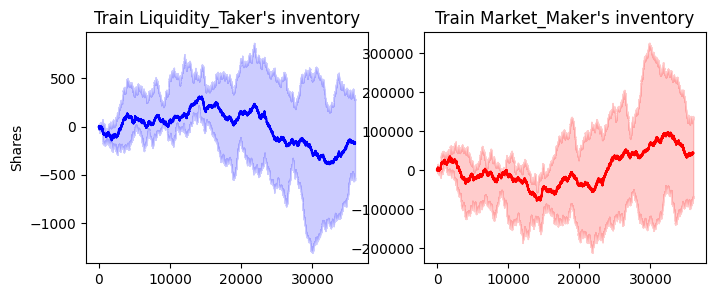

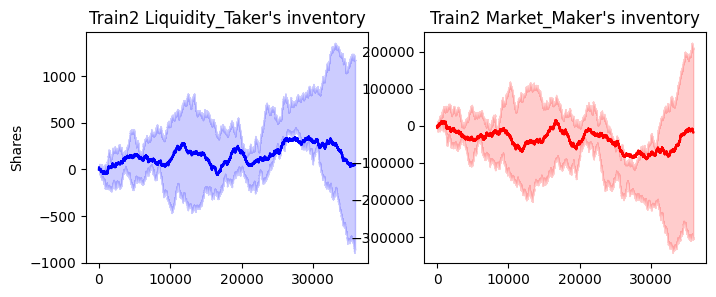

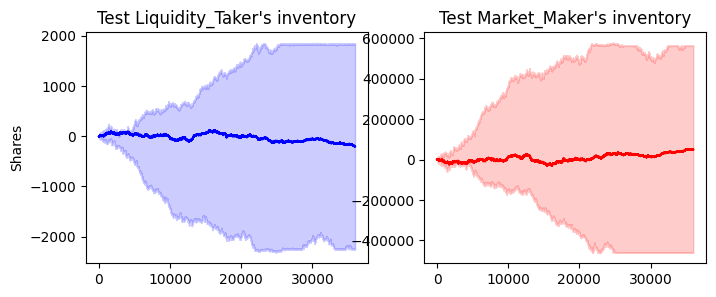

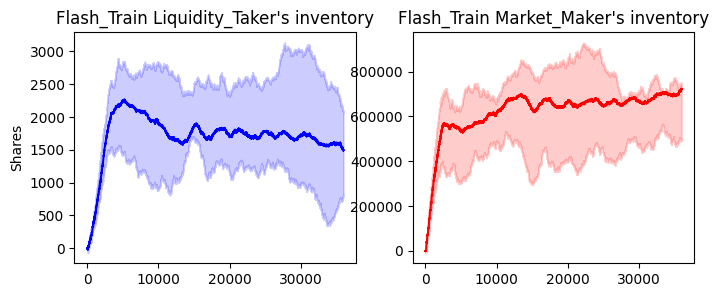

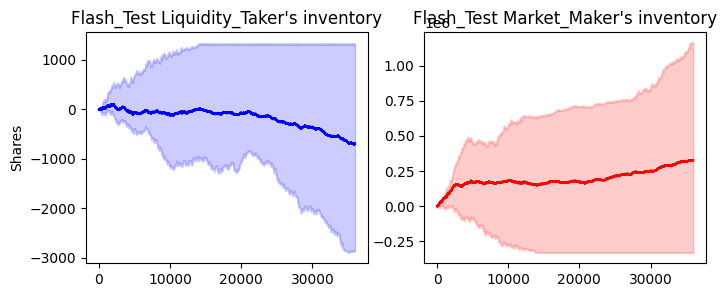

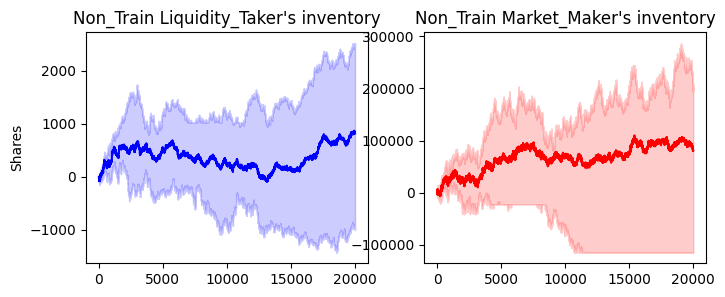

In [17]:
#plot agent inventory
agent_plot(train_data, "inventory", "Train")
agent_plot(train2_data, "inventory", "Train2")
agent_plot(test_data, "inventory", "Test")
agent_plot(flash_train_data, "inventory", "Flash_Train")
agent_plot(flash_test_data, "inventory", "Flash_Test")
agent_plot(non_train_data, "inventory", "Non_Train")

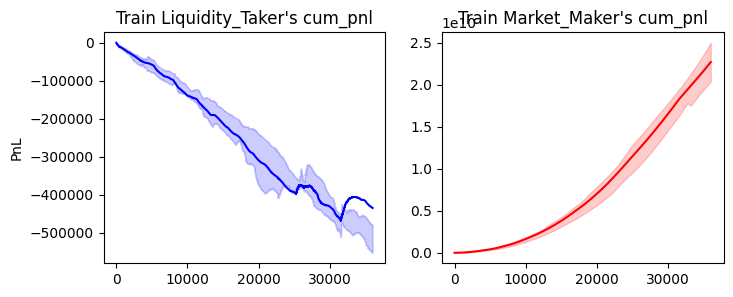

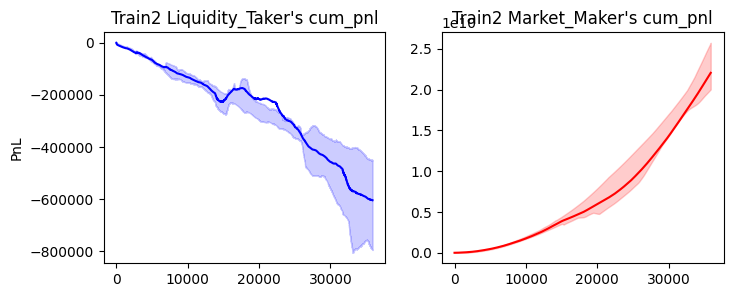

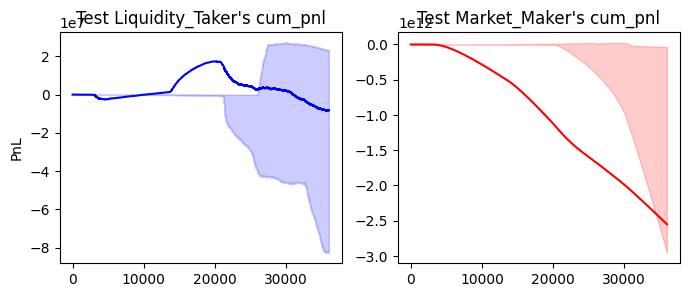

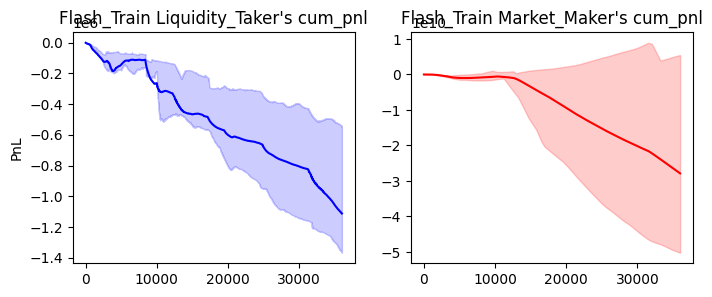

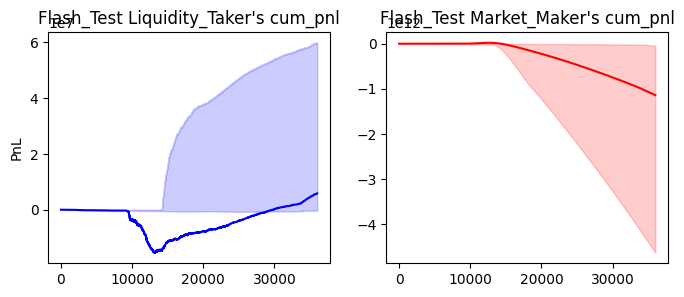

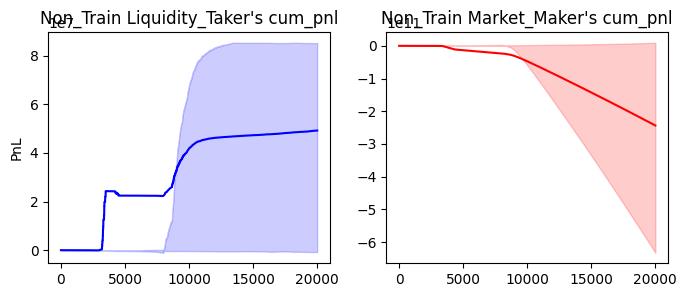

In [18]:
#plot agent cum_pnl
agent_plot(train_data, "cum_pnl", "Train")
agent_plot(train2_data, "cum_pnl", "Train2")
agent_plot(test_data, "cum_pnl", "Test")
agent_plot(flash_train_data, "cum_pnl", "Flash_Train")
agent_plot(flash_test_data, "cum_pnl", "Flash_Test")
agent_plot(non_train_data, "cum_pnl", "Non_Train")

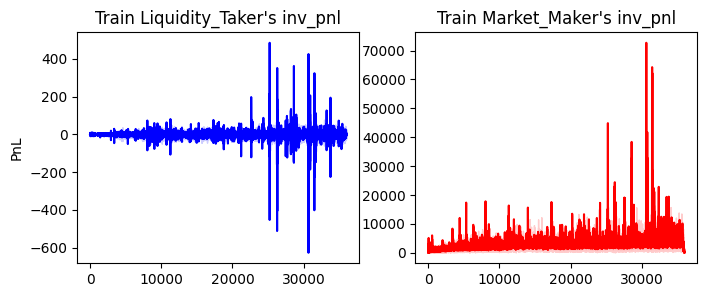

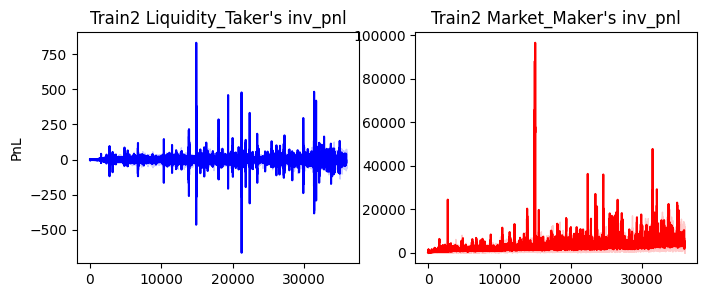

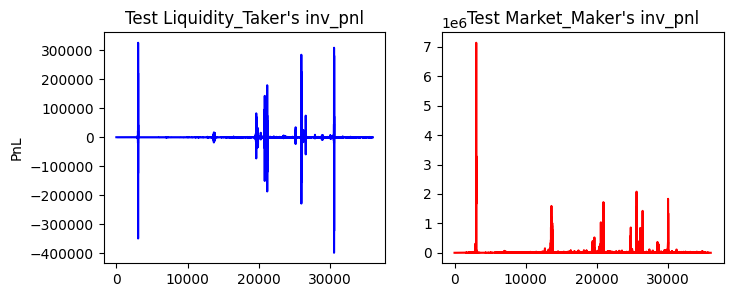

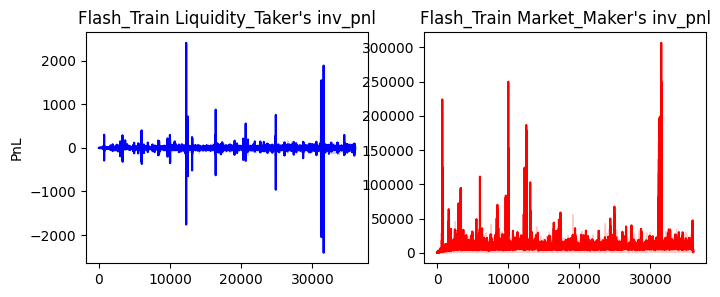

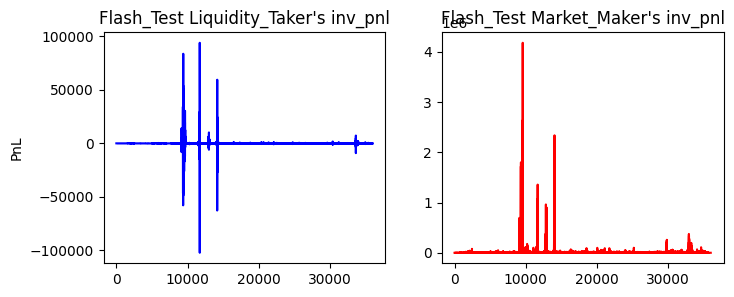

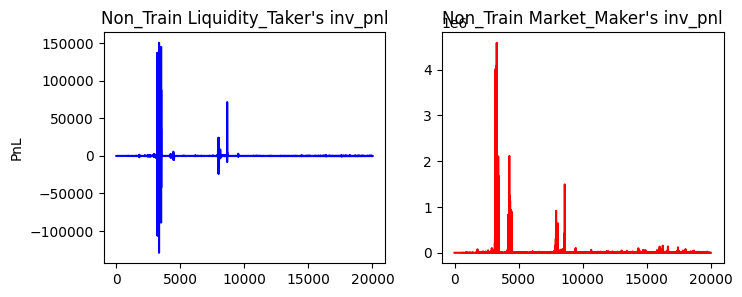

In [19]:
#plot agent inv_pnl
agent_plot(train_data, "inv_pnl", "Train")
agent_plot(train2_data, "inv_pnl", "Train2")
agent_plot(test_data, "inv_pnl", "Test")
agent_plot(flash_train_data, "inv_pnl", "Flash_Train")
agent_plot(flash_test_data, "inv_pnl", "Flash_Test")
agent_plot(non_train_data, "inv_pnl", "Non_Train")

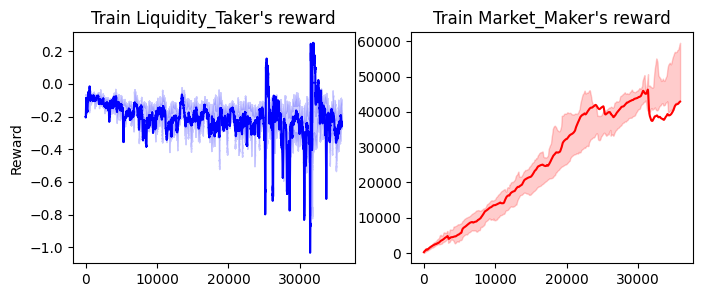

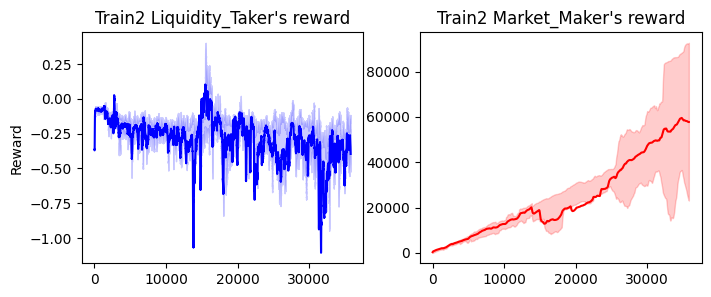

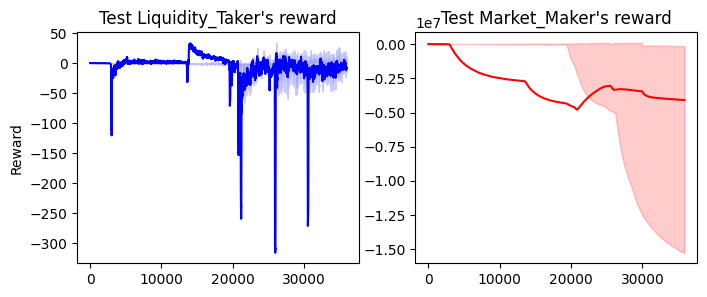

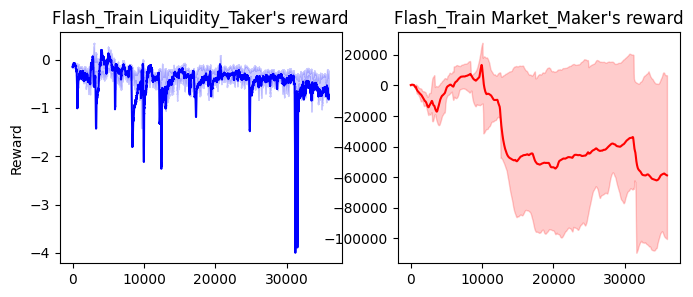

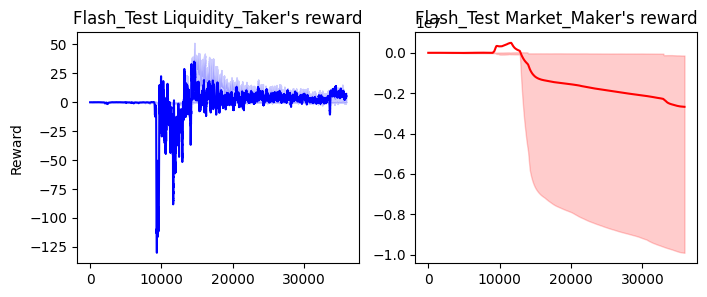

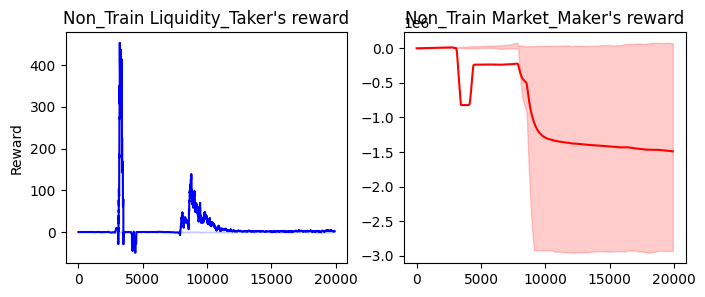

In [230]:
#plot agent reward
agent_plot(train_data, "reward", "Train")
agent_plot(train2_data, "reward", "Train2")
agent_plot(test_data, "reward", "Test")
agent_plot(flash_train_data, "reward", "Flash_Train")
agent_plot(flash_test_data, "reward", "Flash_Test")
agent_plot(non_train_data, "reward", "Non_Train")

Train


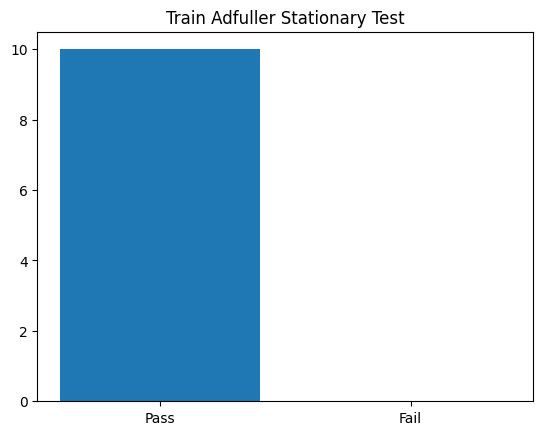

Train2


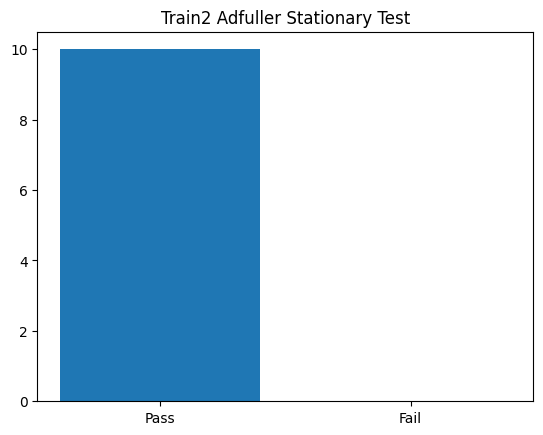

Test


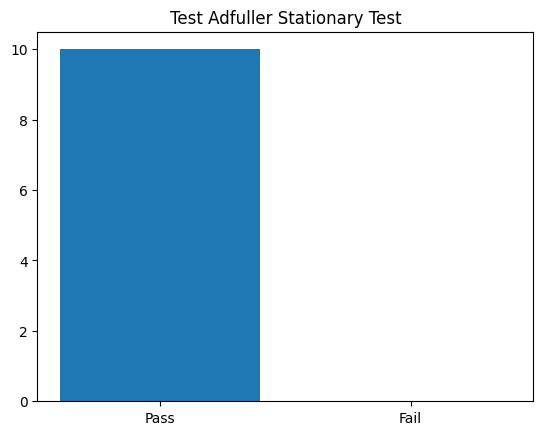

Flash_Train


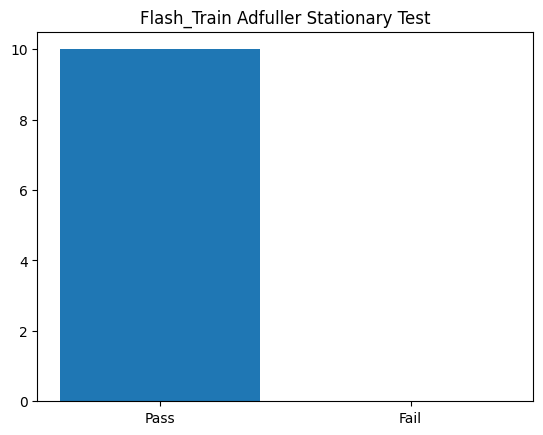

Flash_Test


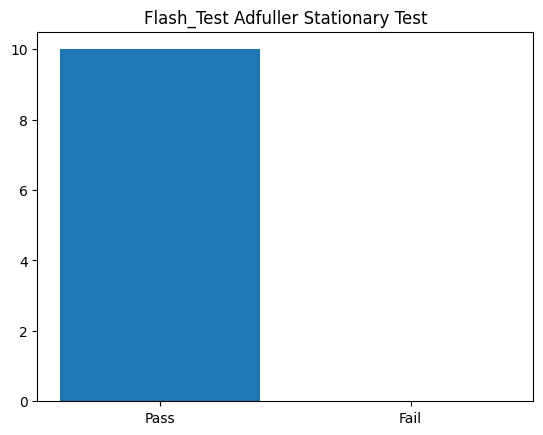

Non_Train


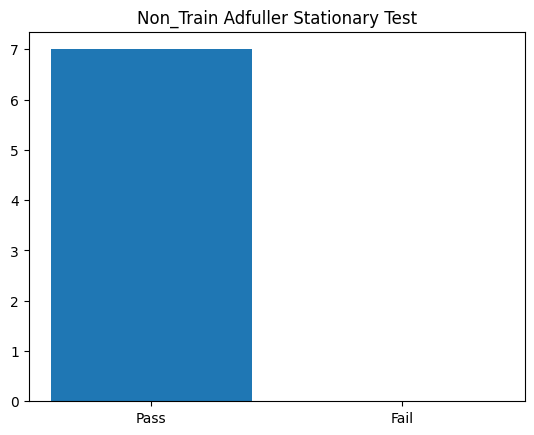

Real


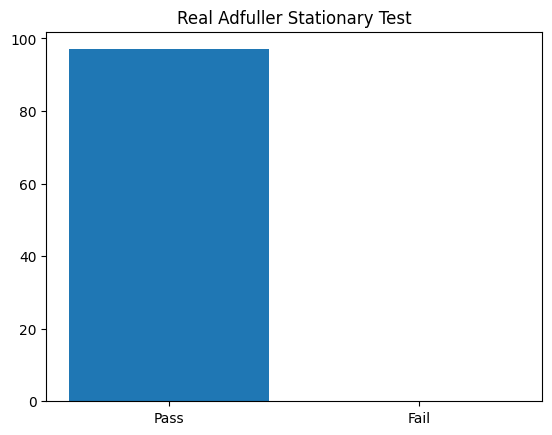

In [24]:
#plot statioanry test results
plot(train_mm, "stationary_test", "Train")
plot(train2_mm, "stationary_test", "Train2")
plot(test_mm, "stationary_test", "Test")
plot(flash_train_mm, "stationary_test", "Flash_Train")
plot(flash_test_mm, "stationary_test", "Flash_Test")
plot(non_train_mm, "stationary_test", "Non_Train")
plot(real_data, "stationary_test", "Real")

In [29]:
data_map = {
    'Train': train_mm,
    'Train2': train2_mm,
    'Test': test_mm,
    "Flash_Train": flash_train_mm,
    "Flash_Test": flash_test_mm,
    "Non_Train": non_train_mm,
    "Real": real_data
}

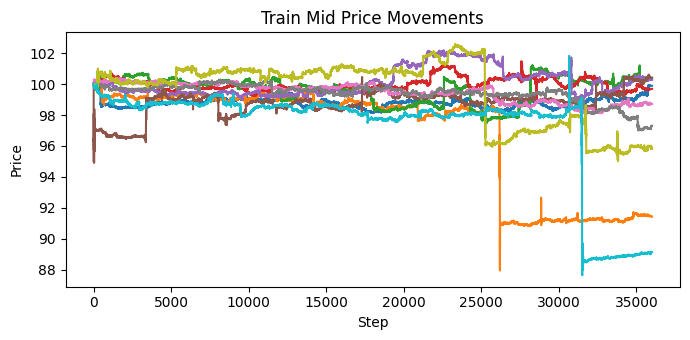

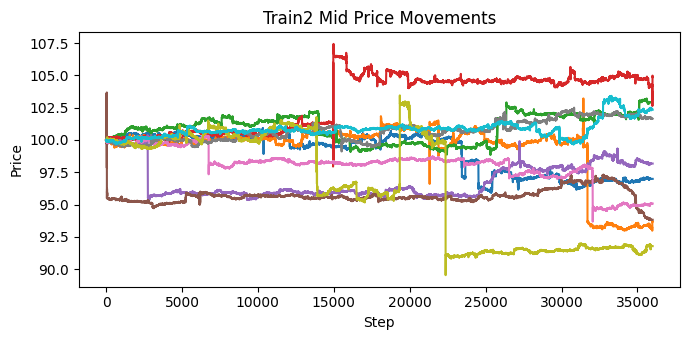

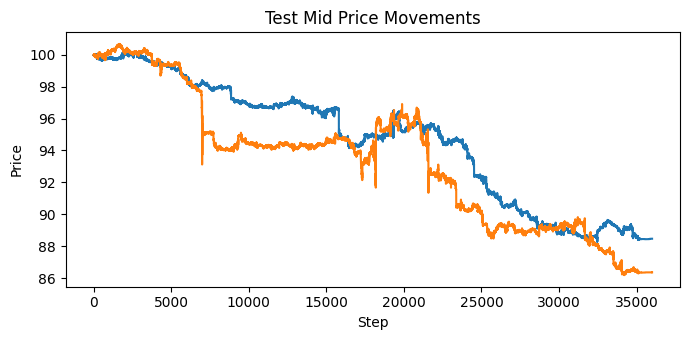

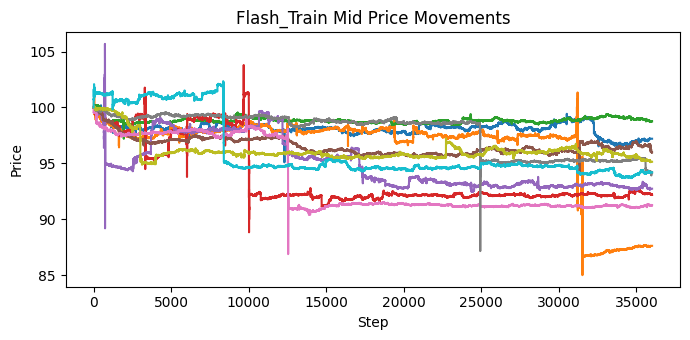

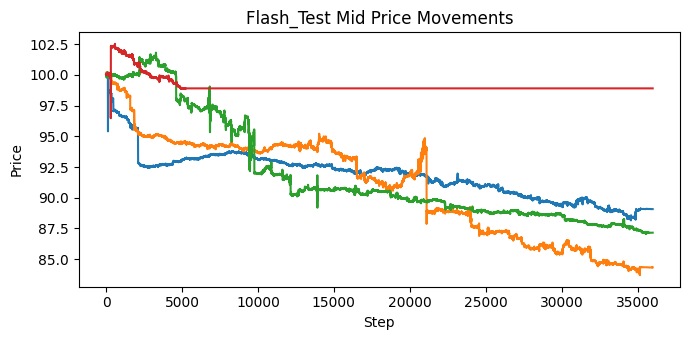

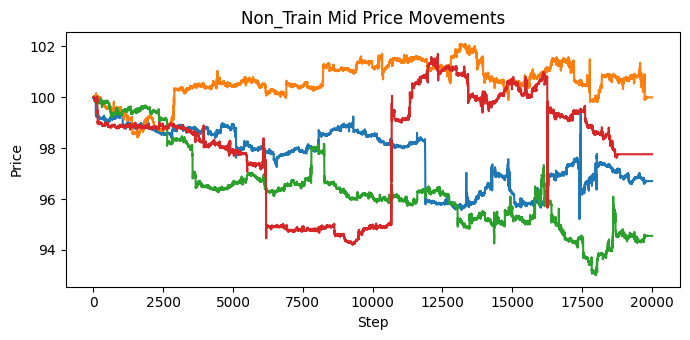

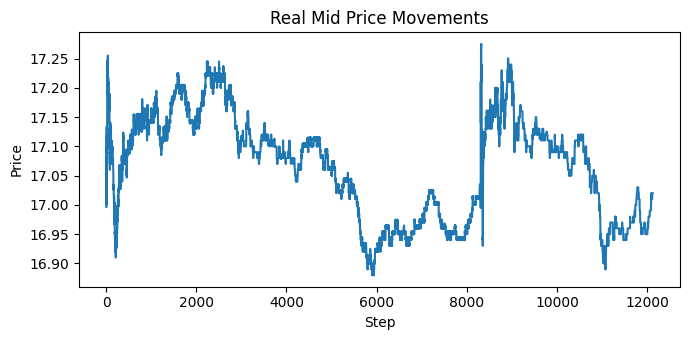

In [275]:
#plot mid prices
plot(train_mm, "mid price", "Train")
plot(train2_mm, "mid price", "Train2")
plot(test_mm, "mid price", "Test")
plot(flash_train_mm, "mid price", "Flash_Train")
plot(flash_test_mm, "mid price", "Flash_Test")
plot(non_train_mm, "mid price", "Non_Train")
plot(real_data, "mid price", "Real")

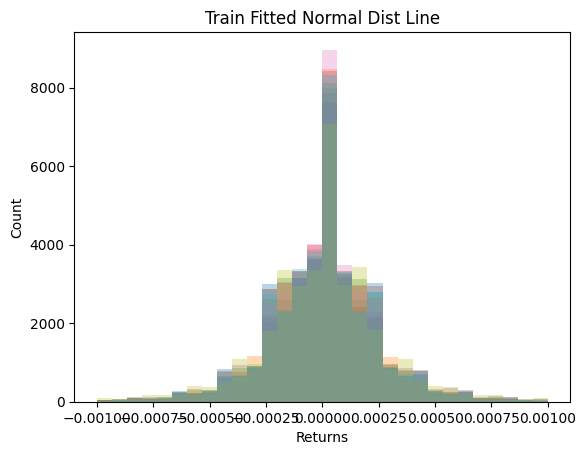

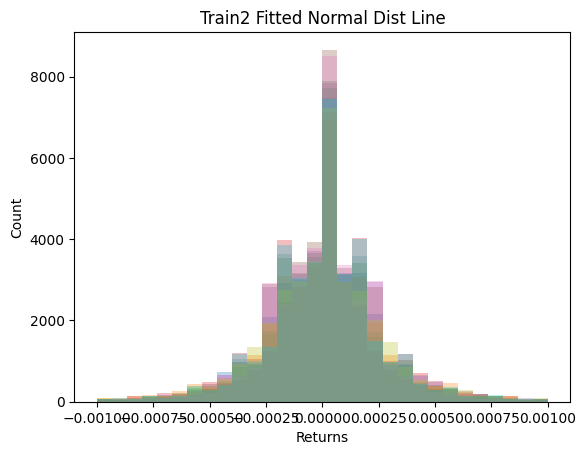

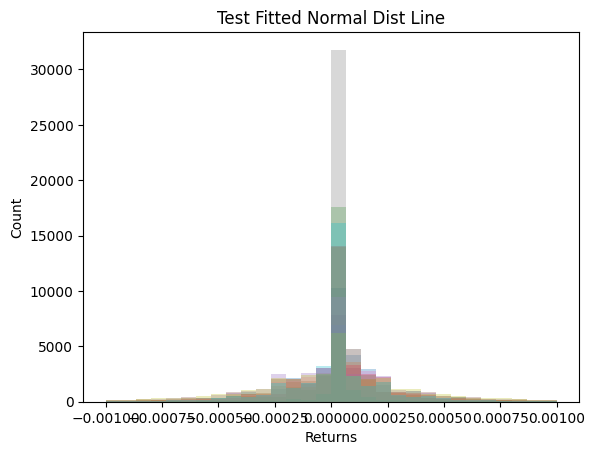

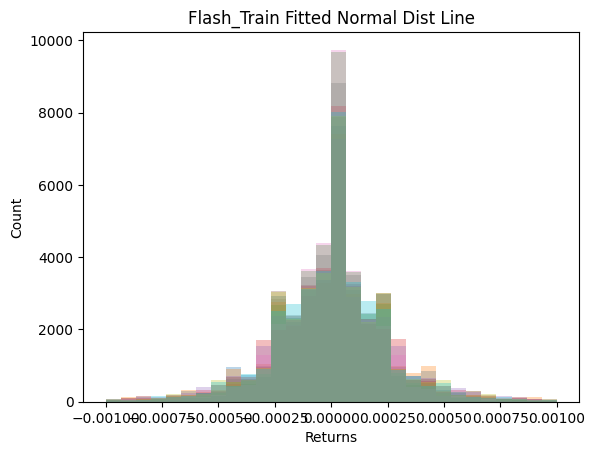

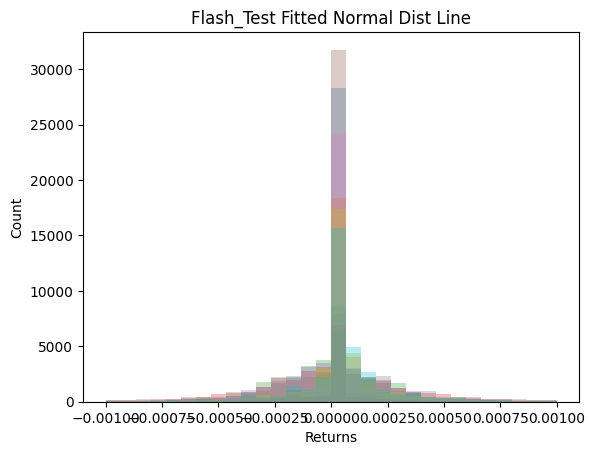

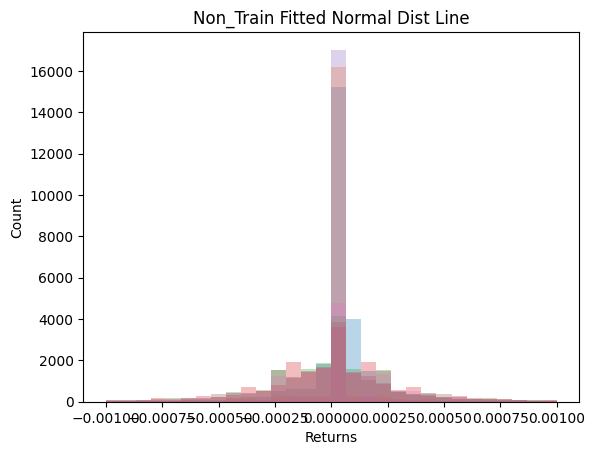

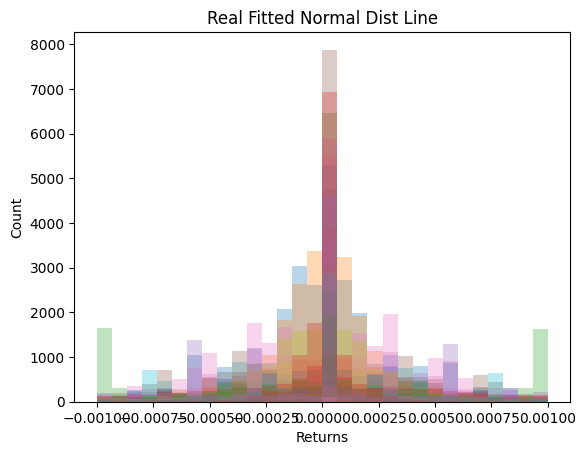

In [26]:
#plot return histgram
plot(train_mm, "normal dist", "Train")
plot(train2_mm, "normal dist", "Train2")
plot(test_mm, "normal dist", "Test")
plot(flash_train_mm, "normal dist", "Flash_Train")
plot(flash_test_mm, "normal dist", "Flash_Test")
plot(non_train_mm, "normal dist", "Non_Train")
plot(real_data, "normal dist", "Real")

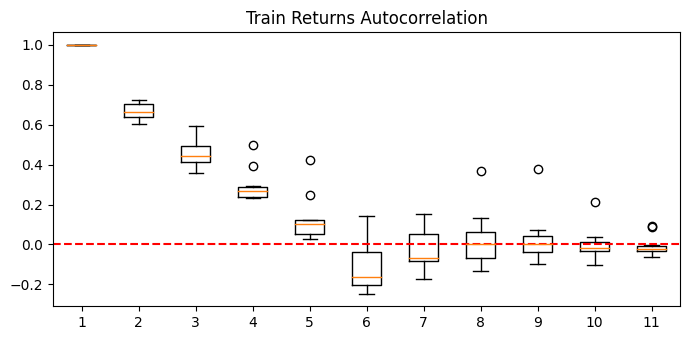

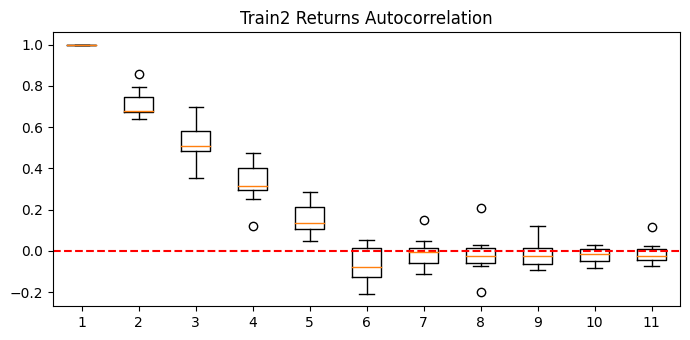

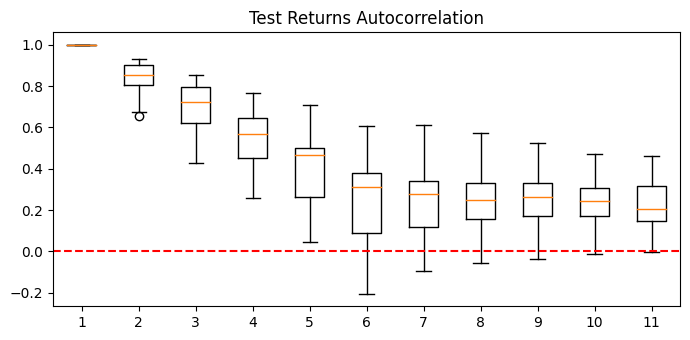

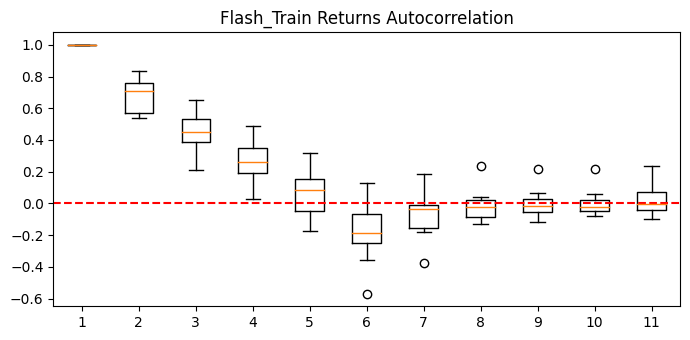

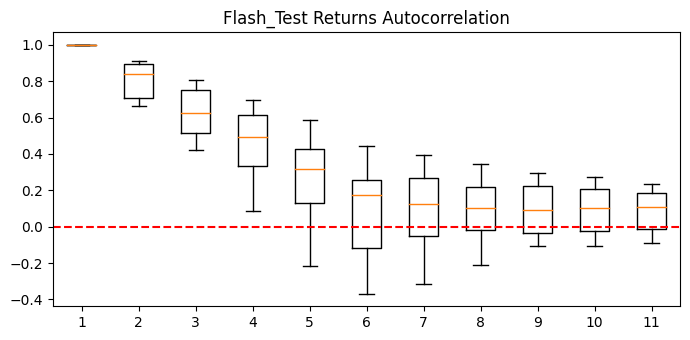

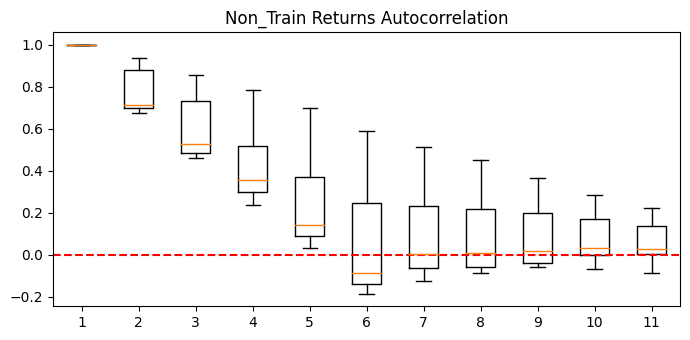

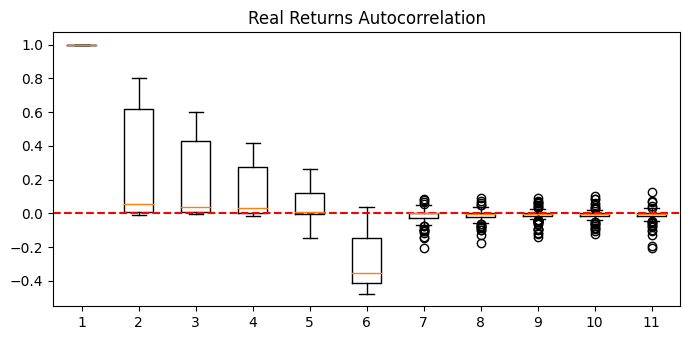

In [277]:
#plot return autocorrelation
plot(train_mm, "return autocorr", "Train")
plot(train2_mm, "return autocorr", "Train2")
plot(test_mm, "return autocorr", "Test")
plot(flash_train_mm, "return autocorr", "Flash_Train")
plot(flash_test_mm, "return autocorr", "Flash_Test")
plot(non_train_mm, "return autocorr", "Non_Train")
plot(real_data, "return autocorr", "Real")

In [282]:
plot(train_mm, "returns statistics", "Train")
plot(train2_mm, "returns statistics", "Train2")
plot(test_mm, "returns statistics", "Test")
plot(flash_train_mm, "returns statistics", "Flash_Train")
plot(flash_test_mm, "returns statistics", "Flash_Test")
plot(non_train_mm, "returns statistics", "Non_Train")
plot(real_data, "returns statisticsr", "Real")

Train #################
   Key   Skewness     Kurtosis     Anderson
0    1  -3.682694   117.674651   977.232188
1    2 -33.442183  2265.253222  6577.330768
2    3   2.835056   251.371772  3378.627645
3    4   3.552820   196.127307  2606.776376
4    5  -5.697915   238.555693  1880.711953
5    6  -4.105515   569.977790  5240.220997
6    7  -1.035768    24.827690   687.429830
7    8  -1.645642    73.803505   984.455624
8    9 -10.875104   435.797871  4107.941304
9   10 -33.935223  1846.308988  7508.648834
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


<Figure size 1000x400 with 0 Axes>

Train2 #################
   Key   Skewness     Kurtosis     Anderson
0    1  -3.936324   193.481268  3171.608899
1    2 -13.625734  1360.740037  6146.527225
2    3   1.727213   207.422681  2546.154063
3    4  42.192769  3227.970459  6530.267683
4    5 -29.800984  1793.052160  4326.861648
5    6 -38.439790  3186.153289  7136.356234
6    7 -26.882718  1338.835465  3713.089821
7    8  -2.153757   104.317030  1912.850131
8    9 -13.680079  2121.724641  7773.668234
9   10  -0.722354    91.660141  1574.296063
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


<Figure size 1000x400 with 0 Axes>

Test #################
   Key   Skewness     Kurtosis      Anderson
0    1  70.856441  5793.225863  12874.058219
1    2  30.950405  1189.612506  12059.309967
2    3  36.203082  1841.467835  12812.239476
3    4  59.224456  3923.301523  13058.545237
4    5  -2.240227    85.927409   1916.425334
5    6  69.239742  5593.522187  12466.144933
6    7  34.993718  1407.163816  12363.150110
7    8  75.238614  6000.203351  13720.124213
8    9  -2.561164   252.340240   3665.508402
9   10  45.867546  2507.272107  13120.565649
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


<Figure size 1000x400 with 0 Axes>

Flash_Train #################
   Key   Skewness     Kurtosis     Anderson
0    1   3.734993   842.005640  3099.874425
1    2 -22.525691  1462.577106  8821.448618
2    3  -1.828341   489.479400  1467.291684
3    4 -10.961298   769.364820  8738.416070
4    5  -8.362197  2572.157439  8795.609054
5    6   9.433645  1106.523383  2310.824890
6    7 -39.504570  3304.626779  8537.304714
7    8 -20.640524  3726.860149  8406.964504
8    9  -8.846622   580.168241  2513.859225
9   10 -15.071314   659.866188  4356.007680
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


<Figure size 1000x400 with 0 Axes>

Flash_Test #################
   Key   Skewness     Kurtosis      Anderson
0    1  36.656300  1549.621365  13340.803628
1    2  68.046648  5214.336626  13290.387776
2    3 -14.155256  1378.517035   3901.864843
3    4 -20.250913  1110.401653   4085.350013
4    5  -5.436679   257.648040   5759.880004
5    6  52.368818  5598.614486  11944.294206
6    7  89.288908  8828.157812  13622.484205
7    8  24.293785   842.119810  10832.317307
8    9  36.417129  1637.198939  12516.405112
9   10  73.310329  6284.271126  13155.790539
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


<Figure size 1000x400 with 0 Axes>

Non_Train #################
   Key   Skewness     Kurtosis      Anderson
0    1  57.471497  3837.961766  10627.158603
1    2  52.641209  3134.713792   7396.455403
2    3  -4.402103   201.324546   2619.899228
3    4  -2.045452    77.963087   1493.248044
4    5  44.250771  2248.887589   7339.318049
5    6   0.129425    61.845231   1713.201329
6    7   4.300221   562.859826   3297.941695
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


<Figure size 1000x400 with 0 Axes>

In [35]:
def plot_return_dist(data_map):
    for key in data_map:
        sns.histplot(np.concatenate([data['returns'].tolist() for data in data_map[key]]), kde = True, label = key)
    plt.legend()
    plt.show()
plot_return_dist(data_map)

KeyboardInterrupt: 

In [33]:
data_map['Train2'][1]['returns'].tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.999750012513182e-05,
 0.0,
 -9.999000099991662e-05,
 -9.999000099991662e-05,
 4.999500049995831e-05,
 9.999000099991662e-05,
 0.00029997000299974985,
 0.00045000000000006146,
 0.00045000000000006146,
 0.00029995500674906417,
 0.00024995000999816774,
 -9.996001599366089e-05,
 -0.0004997751012044693,
 -0.00034984257084313963,
 -0.0005497526113249496,
 -0.0005997301214453188,
 -0.00029991002699192304,
 5.000250012487939e-05,
 -4.999500050006933e-05,
 0.0003000300030002734,
 0.0002000300045006398,
 -0.00014999999999998348,
 -0.00010000000000010001,
 -0.00019999000049997218,
 -0.00039992001599675753,
 -0.0002999850007500138,
 -0.0002000300045006398,
 -0.0002500250025001538,
 -0.0002000300045006398,
 -0.00020004000800166732,
 -5.001250312575145e-05,
 -0.000100035012254307,
 5.001750612709799e-05,
 5.001750612709799e-05,
 0.0003501400560224077,
 -0.000250075022506846,
 -0.0001500675303887089,
 -0.00040012003601075374,
 -0.000250075022506846,
 -0.00060003000150